## Load libraries

In [221]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, make_scorer

In [231]:
from helpers import prediction_plots, query_by_committee, model_evaluation

In [ ]:
import joblib

In [159]:
from sklearn.neighbors import NearestNeighbors

## Create data
* suppose the following has been done too:
    * feature engineering
    * feature selection
    * missing data imputation
    * fix data types
    * using pipeline, scale and normalize features
    * drop highly correlated features

In [3]:
X, y = make_classification(
    n_samples=10000,
    n_features=9,
    n_informative=6,
    n_redundant=1,
    n_repeated=0,
    n_classes=2,
    weights=[0.5, 0.5],
    class_sep=1.0,
    random_state=42
)

In [4]:
df = pd.DataFrame(X, columns=[f"feature_{i}" for i in range(9)])
df['label'] = y

In [86]:
# df.to_csv('data/data.csv', index=False)
df = pd.read_csv('data/data.csv')

In [87]:
df

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,label
0,-1.631493,-0.491771,-1.943438,-2.040475,0.779573,-1.070425,0.490697,-1.408273,-0.668682,0
1,3.585135,-0.946808,2.376782,2.239764,-3.176920,2.106953,0.309647,2.933195,-1.158072,0
2,-2.742050,1.946119,-1.012712,0.685001,-1.908302,1.280182,0.672111,-2.846945,0.034289,0
3,2.221016,-2.114839,-0.581277,-0.918493,-2.130092,1.277796,-1.356373,2.031235,-0.356917,1
4,1.158894,1.254940,1.802472,-1.573036,3.036069,-1.088067,1.846690,0.864903,3.867652,1
...,...,...,...,...,...,...,...,...,...,...
9995,1.254629,0.987995,1.085303,0.754103,-1.873603,2.832344,0.888712,-0.284633,0.166439,0
9996,1.073652,0.185000,0.143480,-2.513347,-2.305778,2.473852,0.231224,-1.293591,-2.147594,0
9997,-0.817159,0.774298,-0.053580,-0.902037,-4.125627,-0.264479,0.278698,-0.891123,-0.002447,0
9998,1.906176,1.968500,2.200580,0.724599,1.300840,-1.436129,0.572093,-1.045775,3.091766,1


## 1. Let's say you don't have the labels
* Because you don't have the labels you need `Active Learning`

In [88]:
X_unlabeled = df.drop('label', axis=1)
X_unlabeled

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8
0,-1.631493,-0.491771,-1.943438,-2.040475,0.779573,-1.070425,0.490697,-1.408273,-0.668682
1,3.585135,-0.946808,2.376782,2.239764,-3.176920,2.106953,0.309647,2.933195,-1.158072
2,-2.742050,1.946119,-1.012712,0.685001,-1.908302,1.280182,0.672111,-2.846945,0.034289
3,2.221016,-2.114839,-0.581277,-0.918493,-2.130092,1.277796,-1.356373,2.031235,-0.356917
4,1.158894,1.254940,1.802472,-1.573036,3.036069,-1.088067,1.846690,0.864903,3.867652
...,...,...,...,...,...,...,...,...,...
9995,1.254629,0.987995,1.085303,0.754103,-1.873603,2.832344,0.888712,-0.284633,0.166439
9996,1.073652,0.185000,0.143480,-2.513347,-2.305778,2.473852,0.231224,-1.293591,-2.147594
9997,-0.817159,0.774298,-0.053580,-0.902037,-4.125627,-0.264479,0.278698,-0.891123,-0.002447
9998,1.906176,1.968500,2.200580,0.724599,1.300840,-1.436129,0.572093,-1.045775,3.091766


In [91]:
# X_unlabeled.to_csv('data/data_unlabeled.csv')
X_unlabeled = pd.read_csv('data/data_unlabeled.csv')
X_unlabeled.shape

(10000, 10)

# Iteration 1 `i1`

## 2. So you manually label 300 samples
* 10,000 is too much, but 300 you can label, and you choose these first 300 taking a random sample of the 10,000

In [52]:
# labeled_indices = np.random.choice(range(10000), size=300, replace=False)
# df[df.index.isin(labeled_indices)].to_csv('data/i1_300_labeled_data.csv')
df_i1 = pd.read_csv('data/i1_300_labeled_data.csv', index_col=0)
df_i1.index.name = None

### There are now 9,700 unlabeled samples (10,000 - 300)

In [53]:
labeled_indices = df_i1.index
len(labeled_indices)

300

In [54]:
print(X_unlabeled.shape)
all_indices = np.arange(len(X_unlabeled))
print(len(all_indices))

(10000, 9)
10000


In [55]:
non_labeled_indices = np.setdiff1d(all_indices, labeled_indices)
print(len(non_labeled_indices))
X_unlabeled = df.iloc[non_labeled_indices].drop(columns='label')
print(X_unlabeled.shape)

9700
(9700, 9)


In [56]:
X_unlabeled

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8
0,-1.631493,-0.491771,-1.943438,-2.040475,0.779573,-1.070425,0.490697,-1.408273,-0.668682
1,3.585135,-0.946808,2.376782,2.239764,-3.176920,2.106953,0.309647,2.933195,-1.158072
2,-2.742050,1.946119,-1.012712,0.685001,-1.908302,1.280182,0.672111,-2.846945,0.034289
3,2.221016,-2.114839,-0.581277,-0.918493,-2.130092,1.277796,-1.356373,2.031235,-0.356917
4,1.158894,1.254940,1.802472,-1.573036,3.036069,-1.088067,1.846690,0.864903,3.867652
...,...,...,...,...,...,...,...,...,...
9995,1.254629,0.987995,1.085303,0.754103,-1.873603,2.832344,0.888712,-0.284633,0.166439
9996,1.073652,0.185000,0.143480,-2.513347,-2.305778,2.473852,0.231224,-1.293591,-2.147594
9997,-0.817159,0.774298,-0.053580,-0.902037,-4.125627,-0.264479,0.278698,-0.891123,-0.002447
9998,1.906176,1.968500,2.200580,0.724599,1.300840,-1.436129,0.572093,-1.045775,3.091766


## 3. Train initial model on 300 labeled samples

### 3.1. Train/Test Split

In [58]:
X = df_i1.drop(columns=['label'])
y = df_i1['label']

In [59]:
X

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8
41,1.108881,1.321525,1.497555,0.262076,-1.712964,0.218810,-0.991417,-1.712821,-0.992199
146,0.960339,3.072138,1.507638,0.286201,-1.126263,0.545994,-2.066957,-3.653898,1.666626
190,-0.175840,-0.097161,-2.908148,0.925595,-0.357026,2.596895,-0.583683,-3.526364,-0.479135
197,2.593124,0.784321,0.477026,1.030054,-2.424044,0.970779,-0.590778,-1.982502,0.980651
224,-0.274208,1.748403,0.956716,-0.503438,-0.652381,1.779665,1.150987,-1.637511,-0.564733
...,...,...,...,...,...,...,...,...,...
9814,-0.566985,2.019449,2.866168,1.136941,-0.925563,-0.411772,-0.246875,-0.223641,-1.463980
9860,-0.946221,1.218273,1.398458,-0.476081,0.099119,-1.648333,-0.038769,0.413502,1.023341
9936,-1.610947,0.997583,-0.823082,0.583725,-3.425701,0.322374,0.733609,-1.460359,0.513327
9945,1.494231,0.837152,0.369113,-0.701718,-0.834904,-1.973791,1.487620,-1.903681,1.888732


In [60]:
y.value_counts()

label
0    162
1    138
Name: count, dtype: int64

### 3.2. Nested Cross-Validation
* Nested Cross-Validation
    * Wraps Grid Search inside an outer Cross-Validation loop to get an unbiased estimate of model performance, especially when tuning hyperparameters.

* Grid Search
    * Hyperparameter Tuning (Regularization Strength) with Cross-Validation

In [61]:
# Define hyperparameter space and CV strategies
param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100]}
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# Perform nested CV
fold_results = []
all_best_params = []

for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):
    X_train_outer, X_test_outer = X.iloc[train_idx], X.iloc[test_idx]
    y_train_outer, y_test_outer = y.iloc[train_idx], y.iloc[test_idx]
    
    # Inner Grid Search
    grid_search = GridSearchCV(
        estimator=LogisticRegression(max_iter=500, random_state=42),
        param_grid=param_grid,
        cv=inner_cv,
        scoring='f1',
        n_jobs=-1
    )
    grid_search.fit(X_train_outer, y_train_outer)
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    all_best_params.append(best_params)
    
    # Outer evaluation
    y_pred_outer = best_model.predict(X_test_outer)
    precision = precision_score(y_test_outer, y_pred_outer)
    recall = recall_score(y_test_outer, y_pred_outer)
    f1 = f1_score(y_test_outer, y_pred_outer)
    
    # Store fold results
    fold_results.append({
        "Fold": f"Fold {fold_idx}",
        "Precision": round(precision, 3),
        "Recall": round(recall, 3),
        "F1 Score": round(f1, 3),
        "Best Params": best_params
    })

In [62]:
# Step 5: Build results DataFrame
results_df = pd.DataFrame(fold_results)

# Step 6: Determine most frequent best params and retrain on full labeled set
best_overall_params = pd.DataFrame(all_best_params).mode().iloc[0].to_dict()
final_model = LogisticRegression(**best_overall_params, max_iter=500, random_state=42)
final_model.fit(X, y)

LogisticRegression(max_iter=500, random_state=42)

In [102]:
joblib.dump(final_model, "model/i1_logistic_pipeline_v1.pkl")

['model/i1_logistic_pipeline_v1.pkl']

In [63]:
results_df

,Fold,Precision,Recall,F1 Score,Best Params
0,Fold 1,0.826,0.704,0.760,{'C': 0.1}
1,Fold 2,0.778,0.778,0.778,{'C': 1}
2,Fold 3,0.897,0.929,0.912,{'C': 10}
3,Fold 4,0.724,0.750,0.737,{'C': 1}
4,Fold 5,0.840,0.750,0.792,{'C': 10}


In [64]:
best_overall_params

{'C': 1.0}

## 4. Use the model to Predict on all samples

In [65]:
X_unlabeled

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8
0,-1.631493,-0.491771,-1.943438,-2.040475,0.779573,-1.070425,0.490697,-1.408273,-0.668682
1,3.585135,-0.946808,2.376782,2.239764,-3.176920,2.106953,0.309647,2.933195,-1.158072
2,-2.742050,1.946119,-1.012712,0.685001,-1.908302,1.280182,0.672111,-2.846945,0.034289
3,2.221016,-2.114839,-0.581277,-0.918493,-2.130092,1.277796,-1.356373,2.031235,-0.356917
4,1.158894,1.254940,1.802472,-1.573036,3.036069,-1.088067,1.846690,0.864903,3.867652
...,...,...,...,...,...,...,...,...,...
9995,1.254629,0.987995,1.085303,0.754103,-1.873603,2.832344,0.888712,-0.284633,0.166439
9996,1.073652,0.185000,0.143480,-2.513347,-2.305778,2.473852,0.231224,-1.293591,-2.147594
9997,-0.817159,0.774298,-0.053580,-0.902037,-4.125627,-0.264479,0.278698,-0.891123,-0.002447
9998,1.906176,1.968500,2.200580,0.724599,1.300840,-1.436129,0.572093,-1.045775,3.091766


In [66]:
new_probabilities = final_model.predict_proba(X_unlabeled)[:, 1]  # Get probability scores
X_unlabeled["Prediction_Probability"] = new_probabilities

In [67]:
threshold = 0.50
lower_threshold = threshold - 0.05
upper_threshold = threshold + 0.05
highlight_bins = [f"({lower_threshold}, {threshold}]", f"({threshold}, {upper_threshold}]"]
sample_size = 68
print(highlight_bins)

['(0.45, 0.5]', '(0.5, 0.55]']


In [68]:
# Add predictions to the new dataset
X_unlabeled["Predicted_Label"] = [1 if prob > threshold else 0 for prob in X_unlabeled["Prediction_Probability"]]

## 5. Use `Uncertainty Sampling` to find out what to label on the next iteration
* From the most uncertain, find 68 samples to manually label them

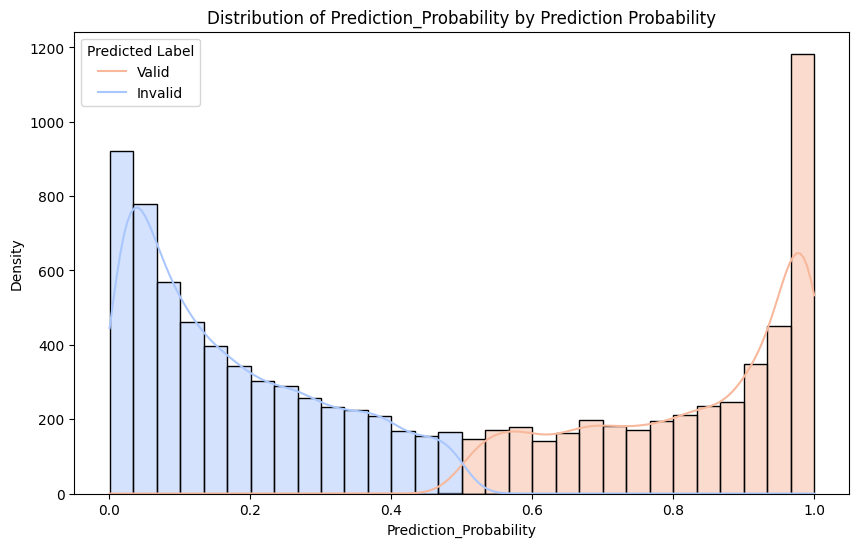

In [69]:
prediction_plots.plot_prediction_distribution(X_unlabeled, "Prediction_Probability")

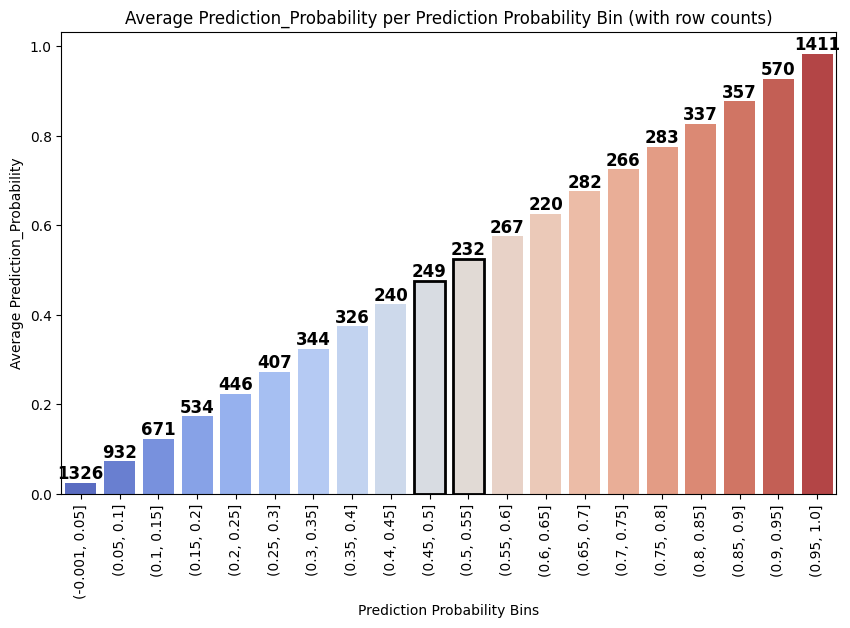

In [70]:
prediction_plots.plot_prediction_probability_bins_with_highlight(X_unlabeled, "Prediction_Probability",
                                                                highlight_bins = highlight_bins)

In [71]:
(
    X_unlabeled[ (X_unlabeled['Prediction_Probability'] <= lower_threshold) ].shape[0], 
    X_unlabeled[ (X_unlabeled['Prediction_Probability'] > lower_threshold) & (X_unlabeled['Prediction_Probability'] <= upper_threshold) ].shape[0], 
    X_unlabeled[ (X_unlabeled['Prediction_Probability'] > upper_threshold) ].shape[0]
)

(5226, 481, 3993)

In [72]:
new_samples = X_unlabeled[ (X_unlabeled['Prediction_Probability'] > lower_threshold) & (X_unlabeled['Prediction_Probability'] <= upper_threshold) ].\
    sample(sample_size, random_state=42)
new_samples

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,Prediction_Probability,Predicted_Label,Probability_Bin
1394,2.739234,0.646543,-0.107681,-0.484614,-1.606893,1.326491,2.834394,-2.694333,0.883339,0.526844,1,"(0.5, 0.55]"
8511,-0.303802,-1.204585,-1.658201,-0.241537,-2.084536,2.080471,0.531608,0.639175,-0.604190,0.514246,1,"(0.5, 0.55]"
7951,1.892434,0.114683,-0.690537,-1.780448,-0.705948,2.535549,0.102084,-2.112947,-0.276877,0.458478,0,"(0.45, 0.5]"
5180,1.771764,-0.429816,1.737218,0.808126,1.482081,-2.934273,1.698120,0.024673,-1.962850,0.486648,0,"(0.45, 0.5]"
8093,2.931026,-0.095903,-0.074970,1.099011,-0.184211,0.195849,-0.770944,-2.006540,0.332695,0.493017,0,"(0.45, 0.5]"
...,...,...,...,...,...,...,...,...,...,...,...,...
2518,0.994529,-0.507498,-1.136315,0.500764,-2.055144,2.339133,0.224526,-0.416994,0.379301,0.548580,1,"(0.5, 0.55]"
9126,0.631906,-0.586227,-2.162309,-0.676762,0.097752,1.598857,2.248088,-2.484922,-0.697887,0.498490,0,"(0.45, 0.5]"
5439,2.666449,0.052676,0.243464,-0.250725,-2.443909,3.571935,0.962673,-0.499395,0.172440,0.504212,1,"(0.5, 0.55]"
6340,1.979074,-1.802447,-2.787430,-1.099227,0.101368,3.407289,-1.446098,-1.802982,-1.376648,0.475954,0,"(0.45, 0.5]"


## 6. You've manually labeled another 68 samples
* Let's add them to the train set and train another model and see the performance

In [75]:
df_i1_68_labeled = df[df['label'].index.isin(new_samples.index)]
df_i1_68_labeled

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,label
15,1.628821,1.613418,1.909759,1.237112,-1.556058,1.458939,1.952518,-0.757754,0.733814,0
164,-0.935573,0.987366,-3.194257,1.099771,0.272836,2.921731,-0.125132,-4.329603,1.688071,1
247,1.913506,1.006126,1.546229,-1.093917,-1.878892,1.662786,-0.153493,-0.393223,0.391884,0
425,0.457592,1.377242,0.914032,1.503539,0.482565,-0.283429,0.638252,-1.588663,0.618789,1
544,-1.975791,0.547451,-1.826279,-0.199572,-1.217368,0.561206,1.787138,-1.626695,0.857566,0
...,...,...,...,...,...,...,...,...,...,...
9576,1.685745,-0.084394,-1.071605,-0.498761,1.683749,0.538403,0.417237,-3.098307,-0.656128,1
9651,2.823113,0.383602,0.757260,-0.771219,-1.267427,1.473578,-0.676014,-1.177734,0.317215,0
9682,1.142094,0.533675,2.098173,0.370450,2.727748,-1.042601,-0.639718,-0.423330,-2.055083,1
9840,1.221775,-0.406764,-3.097079,0.920979,1.453503,3.039516,-0.055204,-4.072893,-0.157196,1


In [78]:
pd.concat([df_i1, df_i1_68_labeled]).to_csv('data/i2_368_labeled_data.csv')

# Iteration 2 `i2`

## 7. So now you have manually labeled 368 samples in total
* 300 to start with iteration 1
* 68 to start with iteration 2

In [ ]:
df_i2 = pd.read_csv('data/i2_368_labeled_data.csv', index_col=0)

In [92]:
X_unlabeled = pd.read_csv('data/data_unlabeled.csv')
X_unlabeled.shape

(10000, 10)

### There are now 9,632 unlabeled samples (10,000 - 368)

In [93]:
labeled_indices = df_i2.index
len(labeled_indices)

368

In [94]:
print(X_unlabeled.shape)
all_indices = np.arange(len(X_unlabeled))
print(len(all_indices))

(10000, 10)
10000


In [95]:
non_labeled_indices = np.setdiff1d(all_indices, labeled_indices)
print(len(non_labeled_indices))
X_unlabeled = df.iloc[non_labeled_indices].drop(columns='label')
print(X_unlabeled.shape)

9632
(9632, 9)


In [96]:
X_unlabeled

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8
0,-1.631493,-0.491771,-1.943438,-2.040475,0.779573,-1.070425,0.490697,-1.408273,-0.668682
1,3.585135,-0.946808,2.376782,2.239764,-3.176920,2.106953,0.309647,2.933195,-1.158072
2,-2.742050,1.946119,-1.012712,0.685001,-1.908302,1.280182,0.672111,-2.846945,0.034289
3,2.221016,-2.114839,-0.581277,-0.918493,-2.130092,1.277796,-1.356373,2.031235,-0.356917
4,1.158894,1.254940,1.802472,-1.573036,3.036069,-1.088067,1.846690,0.864903,3.867652
...,...,...,...,...,...,...,...,...,...
9995,1.254629,0.987995,1.085303,0.754103,-1.873603,2.832344,0.888712,-0.284633,0.166439
9996,1.073652,0.185000,0.143480,-2.513347,-2.305778,2.473852,0.231224,-1.293591,-2.147594
9997,-0.817159,0.774298,-0.053580,-0.902037,-4.125627,-0.264479,0.278698,-0.891123,-0.002447
9998,1.906176,1.968500,2.200580,0.724599,1.300840,-1.436129,0.572093,-1.045775,3.091766


## 8. Train model on 368 labeled samples

### 8.1. Train/Test Split

In [97]:
X = df_i2.drop(columns=['label'])
y = df_i2['label']

In [98]:
X

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8
41,1.108881,1.321525,1.497555,0.262076,-1.712964,0.218810,-0.991417,-1.712821,-0.992199
146,0.960339,3.072138,1.507638,0.286201,-1.126263,0.545994,-2.066957,-3.653898,1.666626
190,-0.175840,-0.097161,-2.908148,0.925595,-0.357026,2.596895,-0.583683,-3.526364,-0.479135
197,2.593124,0.784321,0.477026,1.030054,-2.424044,0.970779,-0.590778,-1.982502,0.980651
224,-0.274208,1.748403,0.956716,-0.503438,-0.652381,1.779665,1.150987,-1.637511,-0.564733
...,...,...,...,...,...,...,...,...,...
9576,1.685745,-0.084394,-1.071605,-0.498761,1.683749,0.538403,0.417237,-3.098307,-0.656128
9651,2.823113,0.383602,0.757260,-0.771219,-1.267427,1.473578,-0.676014,-1.177734,0.317215
9682,1.142094,0.533675,2.098173,0.370450,2.727748,-1.042601,-0.639718,-0.423330,-2.055083
9840,1.221775,-0.406764,-3.097079,0.920979,1.453503,3.039516,-0.055204,-4.072893,-0.157196


In [99]:
y.value_counts()

label
0    192
1    176
Name: count, dtype: int64

### 8.2. Nested Cross-Validation
* Nested Cross-Validation
    * Wraps Grid Search inside an outer Cross-Validation loop to get an unbiased estimate of model performance, especially when tuning hyperparameters.

* Grid Search
    * Hyperparameter Tuning (Regularization Strength) with Cross-Validation

In [100]:
# Define hyperparameter space and CV strategies
param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100]}
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# Perform nested CV
fold_results = []
all_best_params = []

for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):
    X_train_outer, X_test_outer = X.iloc[train_idx], X.iloc[test_idx]
    y_train_outer, y_test_outer = y.iloc[train_idx], y.iloc[test_idx]
    
    # Inner Grid Search
    grid_search = GridSearchCV(
        estimator=LogisticRegression(max_iter=500, random_state=42),
        param_grid=param_grid,
        cv=inner_cv,
        scoring='f1',
        n_jobs=-1
    )
    grid_search.fit(X_train_outer, y_train_outer)
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    all_best_params.append(best_params)
    
    # Outer evaluation
    y_pred_outer = best_model.predict(X_test_outer)
    precision = precision_score(y_test_outer, y_pred_outer)
    recall = recall_score(y_test_outer, y_pred_outer)
    f1 = f1_score(y_test_outer, y_pred_outer)
    
    # Store fold results
    fold_results.append({
        "Fold": f"Fold {fold_idx}",
        "Precision": round(precision, 3),
        "Recall": round(recall, 3),
        "F1 Score": round(f1, 3),
        "Best Params": best_params
    })

In [103]:
# Step 5: Build results DataFrame
results_df = pd.DataFrame(fold_results)

# Step 6: Determine most frequent best params and retrain on full labeled set
best_overall_params = pd.DataFrame(all_best_params).mode().iloc[0].to_dict()
final_model = LogisticRegression(**best_overall_params, max_iter=500, random_state=42)
final_model.fit(X, y)

LogisticRegression(max_iter=500, random_state=42)

In [104]:
joblib.dump(final_model, "model/i2_logistic_pipeline_v1.pkl")

['model/i2_logistic_pipeline_v1.pkl']

In [105]:
results_df

,Fold,Precision,Recall,F1 Score,Best Params
0,Fold 1,0.774,0.686,0.727,{'C': 10}
1,Fold 2,0.737,0.800,0.767,{'C': 1}
2,Fold 3,0.698,0.833,0.759,{'C': 10}
3,Fold 4,0.718,0.800,0.757,{'C': 1}
4,Fold 5,0.833,0.714,0.769,{'C': 0.01}


In [106]:
best_overall_params

{'C': 1.0}

## 9. Use the model to Predict on all samples

In [107]:
X_unlabeled

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8
0,-1.631493,-0.491771,-1.943438,-2.040475,0.779573,-1.070425,0.490697,-1.408273,-0.668682
1,3.585135,-0.946808,2.376782,2.239764,-3.176920,2.106953,0.309647,2.933195,-1.158072
2,-2.742050,1.946119,-1.012712,0.685001,-1.908302,1.280182,0.672111,-2.846945,0.034289
3,2.221016,-2.114839,-0.581277,-0.918493,-2.130092,1.277796,-1.356373,2.031235,-0.356917
4,1.158894,1.254940,1.802472,-1.573036,3.036069,-1.088067,1.846690,0.864903,3.867652
...,...,...,...,...,...,...,...,...,...
9995,1.254629,0.987995,1.085303,0.754103,-1.873603,2.832344,0.888712,-0.284633,0.166439
9996,1.073652,0.185000,0.143480,-2.513347,-2.305778,2.473852,0.231224,-1.293591,-2.147594
9997,-0.817159,0.774298,-0.053580,-0.902037,-4.125627,-0.264479,0.278698,-0.891123,-0.002447
9998,1.906176,1.968500,2.200580,0.724599,1.300840,-1.436129,0.572093,-1.045775,3.091766


In [108]:
new_probabilities = final_model.predict_proba(X_unlabeled)[:, 1]  # Get probability scores
X_unlabeled["Prediction_Probability"] = new_probabilities

In [109]:
threshold = 0.50
lower_threshold = threshold - 0.05
upper_threshold = threshold + 0.05
highlight_bins = [f"({lower_threshold}, {threshold}]", f"({threshold}, {upper_threshold}]"]
sample_size = 68
print(highlight_bins)

['(0.45, 0.5]', '(0.5, 0.55]']


In [110]:
# Add predictions to the new dataset
X_unlabeled["Predicted_Label"] = [1 if prob > threshold else 0 for prob in X_unlabeled["Prediction_Probability"]]

## 10. Use `Uncertainty Sampling` to find out what to label on the next iteration
* From the most uncertain, find 68 samples to manually label them

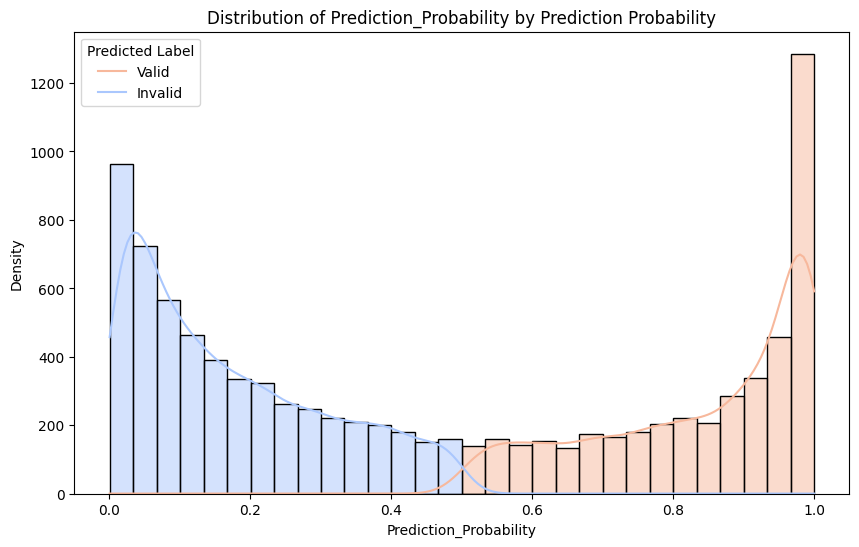

In [111]:
prediction_plots.plot_prediction_distribution(X_unlabeled, "Prediction_Probability")

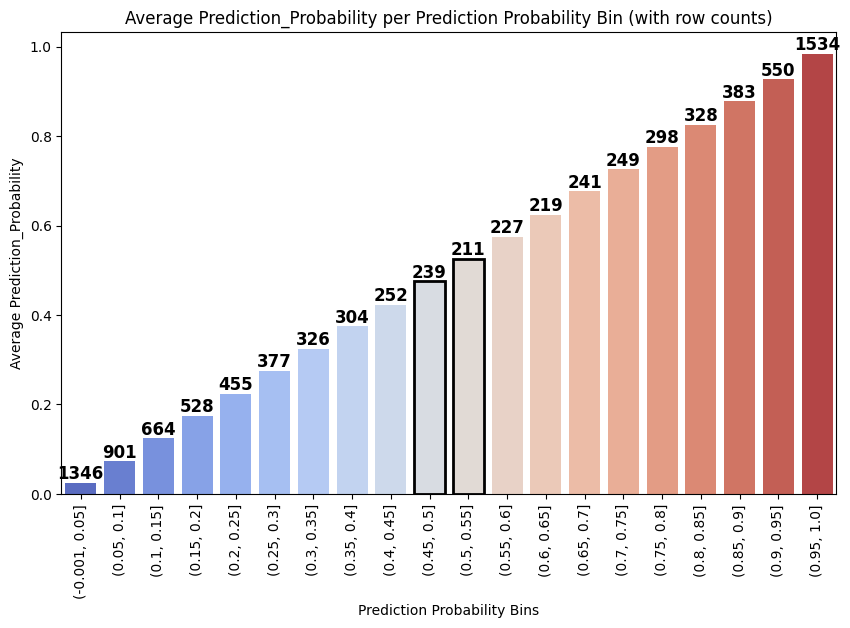

In [112]:
prediction_plots.plot_prediction_probability_bins_with_highlight(X_unlabeled, "Prediction_Probability",
                                                                highlight_bins = highlight_bins)

In [113]:
(
    X_unlabeled[ (X_unlabeled['Prediction_Probability'] <= lower_threshold) ].shape[0], 
    X_unlabeled[ (X_unlabeled['Prediction_Probability'] > lower_threshold) & (X_unlabeled['Prediction_Probability'] <= upper_threshold) ].shape[0], 
    X_unlabeled[ (X_unlabeled['Prediction_Probability'] > upper_threshold) ].shape[0]
)

(5153, 450, 4029)

In [114]:
new_samples = X_unlabeled[ (X_unlabeled['Prediction_Probability'] > lower_threshold) & (X_unlabeled['Prediction_Probability'] <= upper_threshold) ].\
    sample(sample_size, random_state=42)
new_samples

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,Prediction_Probability,Predicted_Label,Probability_Bin
8990,2.224114,1.257400,1.162058,0.547353,-1.435911,0.947086,-0.493426,-1.674048,0.986370,0.462964,0,"(0.45, 0.5]"
9927,-0.740246,2.652758,2.564321,0.683305,-3.404892,-3.595271,-0.934756,-0.144853,3.229085,0.529801,1,"(0.5, 0.55]"
2585,2.643234,-0.888722,1.966894,1.910833,-3.186900,-1.242498,0.489706,2.387626,-0.218172,0.480172,0,"(0.45, 0.5]"
713,3.941203,-1.195269,0.020815,-0.387415,-2.486322,3.090929,-1.284462,0.163368,-0.557935,0.506494,1,"(0.5, 0.55]"
9131,2.251961,1.906272,2.142536,-2.646142,-2.601447,-1.120000,-1.263541,-1.719942,1.736602,0.506778,1,"(0.5, 0.55]"
...,...,...,...,...,...,...,...,...,...,...,...,...
6412,1.914866,1.462875,2.566360,-0.984189,-1.761556,0.887389,0.913013,-0.015606,0.419712,0.503669,1,"(0.5, 0.55]"
1330,0.982230,1.377449,-0.166063,-0.533208,-1.285130,3.180671,0.998639,-2.238563,1.015919,0.452564,0,"(0.45, 0.5]"
7743,2.411542,0.862974,-0.749939,2.106399,-1.051033,3.048974,-2.079525,-3.078075,1.359723,0.454661,0,"(0.45, 0.5]"
9990,-0.560938,-0.825475,-1.885063,-1.633832,-1.777723,-2.063444,0.832792,-1.044578,0.453352,0.516321,1,"(0.5, 0.55]"


## 11. You've manually labeled another 68 samples
* Let's add them to the train set and train another model and see the performance

In [115]:
df_i2_68_labeled = df[df['label'].index.isin(new_samples.index)]
df_i2_68_labeled

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,label
23,2.086313,-2.468768,-2.607315,1.289392,-0.552939,3.530369,0.716930,-0.275331,-1.584293,1
319,0.559241,2.351630,0.444123,0.842711,-2.525722,0.119233,2.523887,-2.811737,2.969409,1
369,2.018218,-0.782860,-0.459299,-0.627848,2.541047,0.120337,-0.515366,-2.031187,-2.225292,1
409,-1.104952,-0.038345,-0.680614,1.599838,-2.004664,0.002143,-1.902214,0.551221,0.940230,1
487,-0.493647,-0.198002,-1.689989,0.285314,-0.222718,0.616136,-0.661580,-1.552651,0.038958,1
...,...,...,...,...,...,...,...,...,...,...
9895,1.288091,-3.163413,0.184088,1.229126,1.615824,-4.924385,0.181751,1.974934,-3.889269,0
9927,-0.740246,2.652758,2.564321,0.683305,-3.404892,-3.595271,-0.934756,-0.144853,3.229085,1
9960,1.995863,-1.041551,1.151818,-1.031150,-4.320377,0.375712,0.794027,2.664467,-0.017171,1
9984,-1.742946,0.366840,-2.633159,-0.930406,-3.304196,-2.400253,0.778233,-2.378022,2.904398,0


In [116]:
pd.concat([df_i2, df_i2_68_labeled]).to_csv('data/i3_436_labeled_data.csv')

# Iteration 3 `i3`

## 12. So now you have manually labeled 436 samples in total
* 300 to start with iteration 1 (cummulative total: 300)
* 68 to start with iteration 2 (cummulative total: 368)
* 68 to start with iteration 3 (cummulative total: 436)

In [117]:
df_i3 = pd.read_csv('data/i3_436_labeled_data.csv', index_col=0)

In [118]:
X_unlabeled = pd.read_csv('data/data_unlabeled.csv')
X_unlabeled.shape

(10000, 10)

### There are now 9,564 unlabeled samples (10,000 - 436)

In [119]:
labeled_indices = df_i3.index
len(labeled_indices)

436

In [120]:
print(X_unlabeled.shape)
all_indices = np.arange(len(X_unlabeled))
print(len(all_indices))

(10000, 10)
10000


In [121]:
non_labeled_indices = np.setdiff1d(all_indices, labeled_indices)
print(len(non_labeled_indices))
X_unlabeled = df.iloc[non_labeled_indices].drop(columns='label')
print(X_unlabeled.shape)

9564
(9564, 9)


In [122]:
X_unlabeled

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8
0,-1.631493,-0.491771,-1.943438,-2.040475,0.779573,-1.070425,0.490697,-1.408273,-0.668682
1,3.585135,-0.946808,2.376782,2.239764,-3.176920,2.106953,0.309647,2.933195,-1.158072
2,-2.742050,1.946119,-1.012712,0.685001,-1.908302,1.280182,0.672111,-2.846945,0.034289
3,2.221016,-2.114839,-0.581277,-0.918493,-2.130092,1.277796,-1.356373,2.031235,-0.356917
4,1.158894,1.254940,1.802472,-1.573036,3.036069,-1.088067,1.846690,0.864903,3.867652
...,...,...,...,...,...,...,...,...,...
9995,1.254629,0.987995,1.085303,0.754103,-1.873603,2.832344,0.888712,-0.284633,0.166439
9996,1.073652,0.185000,0.143480,-2.513347,-2.305778,2.473852,0.231224,-1.293591,-2.147594
9997,-0.817159,0.774298,-0.053580,-0.902037,-4.125627,-0.264479,0.278698,-0.891123,-0.002447
9998,1.906176,1.968500,2.200580,0.724599,1.300840,-1.436129,0.572093,-1.045775,3.091766


## 13. Train model on 436 labeled samples

### 13.1. Train/Test Split

In [123]:
X = df_i3.drop(columns=['label'])
y = df_i3['label']

In [124]:
X

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8
41,1.108881,1.321525,1.497555,0.262076,-1.712964,0.218810,-0.991417,-1.712821,-0.992199
146,0.960339,3.072138,1.507638,0.286201,-1.126263,0.545994,-2.066957,-3.653898,1.666626
190,-0.175840,-0.097161,-2.908148,0.925595,-0.357026,2.596895,-0.583683,-3.526364,-0.479135
197,2.593124,0.784321,0.477026,1.030054,-2.424044,0.970779,-0.590778,-1.982502,0.980651
224,-0.274208,1.748403,0.956716,-0.503438,-0.652381,1.779665,1.150987,-1.637511,-0.564733
...,...,...,...,...,...,...,...,...,...
9895,1.288091,-3.163413,0.184088,1.229126,1.615824,-4.924385,0.181751,1.974934,-3.889269
9927,-0.740246,2.652758,2.564321,0.683305,-3.404892,-3.595271,-0.934756,-0.144853,3.229085
9960,1.995863,-1.041551,1.151818,-1.031150,-4.320377,0.375712,0.794027,2.664467,-0.017171
9984,-1.742946,0.366840,-2.633159,-0.930406,-3.304196,-2.400253,0.778233,-2.378022,2.904398


In [125]:
y.value_counts()

label
0    232
1    204
Name: count, dtype: int64

### 13.2. Nested Cross-Validation
* Nested Cross-Validation
    * Wraps Grid Search inside an outer Cross-Validation loop to get an unbiased estimate of model performance, especially when tuning hyperparameters.

* Grid Search
    * Hyperparameter Tuning (Regularization Strength) with Cross-Validation

In [126]:
# Define hyperparameter space and CV strategies
param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100]}
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# Perform nested CV
fold_results = []
all_best_params = []

for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):
    X_train_outer, X_test_outer = X.iloc[train_idx], X.iloc[test_idx]
    y_train_outer, y_test_outer = y.iloc[train_idx], y.iloc[test_idx]
    
    # Inner Grid Search
    grid_search = GridSearchCV(
        estimator=LogisticRegression(max_iter=500, random_state=42),
        param_grid=param_grid,
        cv=inner_cv,
        scoring='f1',
        n_jobs=-1
    )
    grid_search.fit(X_train_outer, y_train_outer)
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    all_best_params.append(best_params)
    
    # Outer evaluation
    y_pred_outer = best_model.predict(X_test_outer)
    precision = precision_score(y_test_outer, y_pred_outer)
    recall = recall_score(y_test_outer, y_pred_outer)
    f1 = f1_score(y_test_outer, y_pred_outer)
    
    # Store fold results
    fold_results.append({
        "Fold": f"Fold {fold_idx}",
        "Precision": round(precision, 3),
        "Recall": round(recall, 3),
        "F1 Score": round(f1, 3),
        "Best Params": best_params
    })

In [127]:
# Step 5: Build results DataFrame
results_df = pd.DataFrame(fold_results)

# Step 6: Determine most frequent best params and retrain on full labeled set
best_overall_params = pd.DataFrame(all_best_params).mode().iloc[0].to_dict()
final_model = LogisticRegression(**best_overall_params, max_iter=500, random_state=42)
final_model.fit(X, y)

LogisticRegression(max_iter=500, random_state=42)

In [128]:
joblib.dump(final_model, "model/i3_logistic_pipeline_v1.pkl")

['model/i3_logistic_pipeline_v1.pkl']

In [129]:
results_df

,Fold,Precision,Recall,F1 Score,Best Params
0,Fold 1,0.812,0.634,0.712,{'C': 0.1}
1,Fold 2,0.705,0.775,0.738,{'C': 1}
2,Fold 3,0.650,0.634,0.642,{'C': 0.1}
3,Fold 4,0.737,0.683,0.709,{'C': 1}
4,Fold 5,0.780,0.780,0.780,{'C': 1}


In [130]:
best_overall_params

{'C': 1.0}

## 14. Use the model to Predict on all samples

In [131]:
X_unlabeled

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8
0,-1.631493,-0.491771,-1.943438,-2.040475,0.779573,-1.070425,0.490697,-1.408273,-0.668682
1,3.585135,-0.946808,2.376782,2.239764,-3.176920,2.106953,0.309647,2.933195,-1.158072
2,-2.742050,1.946119,-1.012712,0.685001,-1.908302,1.280182,0.672111,-2.846945,0.034289
3,2.221016,-2.114839,-0.581277,-0.918493,-2.130092,1.277796,-1.356373,2.031235,-0.356917
4,1.158894,1.254940,1.802472,-1.573036,3.036069,-1.088067,1.846690,0.864903,3.867652
...,...,...,...,...,...,...,...,...,...
9995,1.254629,0.987995,1.085303,0.754103,-1.873603,2.832344,0.888712,-0.284633,0.166439
9996,1.073652,0.185000,0.143480,-2.513347,-2.305778,2.473852,0.231224,-1.293591,-2.147594
9997,-0.817159,0.774298,-0.053580,-0.902037,-4.125627,-0.264479,0.278698,-0.891123,-0.002447
9998,1.906176,1.968500,2.200580,0.724599,1.300840,-1.436129,0.572093,-1.045775,3.091766


In [132]:
new_probabilities = final_model.predict_proba(X_unlabeled)[:, 1]  # Get probability scores
X_unlabeled["Prediction_Probability"] = new_probabilities

In [133]:
threshold = 0.50
lower_threshold = threshold - 0.05
upper_threshold = threshold + 0.05
highlight_bins = [f"({lower_threshold}, {threshold}]", f"({threshold}, {upper_threshold}]"]
sample_size = 68
print(highlight_bins)

['(0.45, 0.5]', '(0.5, 0.55]']


In [134]:
# Add predictions to the new dataset
X_unlabeled["Predicted_Label"] = [1 if prob > threshold else 0 for prob in X_unlabeled["Prediction_Probability"]]

## 15. Use `Uncertainty Sampling` to find out what to label on the next iteration
* From the most uncertain, find 68 samples to manually label them

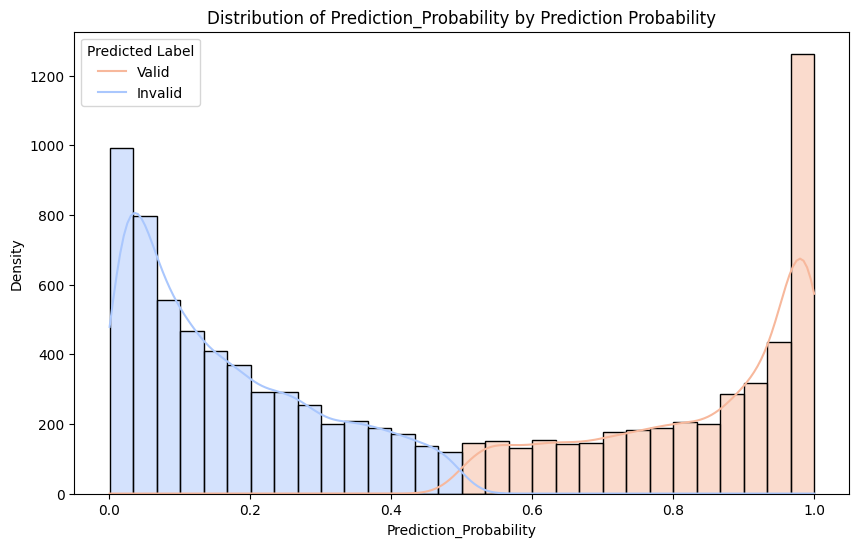

In [135]:
prediction_plots.plot_prediction_distribution(X_unlabeled, "Prediction_Probability")

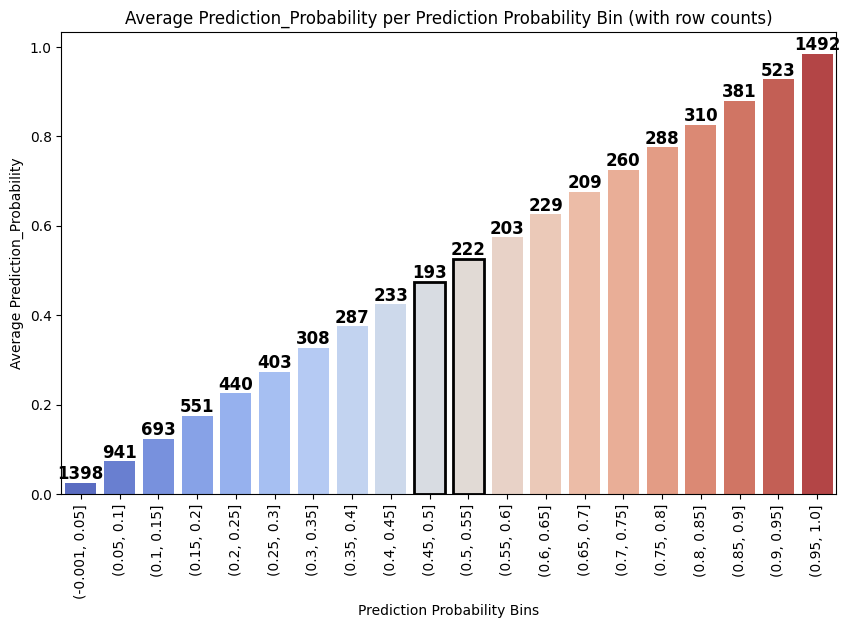

In [136]:
prediction_plots.plot_prediction_probability_bins_with_highlight(X_unlabeled, "Prediction_Probability",
                                                                highlight_bins = highlight_bins)

In [137]:
(
    X_unlabeled[ (X_unlabeled['Prediction_Probability'] <= lower_threshold) ].shape[0], 
    X_unlabeled[ (X_unlabeled['Prediction_Probability'] > lower_threshold) & (X_unlabeled['Prediction_Probability'] <= upper_threshold) ].shape[0], 
    X_unlabeled[ (X_unlabeled['Prediction_Probability'] > upper_threshold) ].shape[0]
)

(5254, 415, 3895)

In [138]:
new_samples = X_unlabeled[ (X_unlabeled['Prediction_Probability'] > lower_threshold) & (X_unlabeled['Prediction_Probability'] <= upper_threshold) ].\
    sample(sample_size, random_state=42)
new_samples

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,Prediction_Probability,Predicted_Label,Probability_Bin
1257,2.059662,0.197026,-0.268333,0.995985,-1.575674,0.907326,0.824922,-1.530570,1.013776,0.549550,1,"(0.5, 0.55]"
3394,-2.298936,-0.255714,-2.579061,-0.635892,1.531048,-0.740178,0.691739,-2.144111,-0.440470,0.514694,1,"(0.5, 0.55]"
4103,1.200215,-1.061575,-1.488115,-0.432688,0.621784,-0.162983,0.676363,-1.684881,-1.001045,0.500327,1,"(0.5, 0.55]"
1286,-0.375237,-1.658001,-2.054874,0.673653,0.261242,-3.091461,0.218824,-0.755941,-0.602571,0.529735,1,"(0.5, 0.55]"
8016,0.812030,1.433740,0.783211,0.099689,-0.485150,1.386659,0.261092,-1.590432,0.640432,0.513021,1,"(0.5, 0.55]"
...,...,...,...,...,...,...,...,...,...,...,...,...
831,1.663410,0.597171,-1.183601,-0.358697,1.069398,0.389281,-1.287324,-4.041686,0.489539,0.542179,1,"(0.5, 0.55]"
8411,0.604254,1.775733,0.463076,-1.182472,1.045916,0.342890,0.848419,-3.224359,0.304821,0.482068,0,"(0.45, 0.5]"
7414,-4.260782,1.320121,-2.665608,0.352334,2.607297,-0.990211,-0.596870,-3.584123,0.496315,0.462791,0,"(0.45, 0.5]"
6064,2.429192,-0.696074,-0.256849,-1.473296,-1.649421,2.908470,1.054741,-0.266010,-0.700426,0.502213,1,"(0.5, 0.55]"


## 16. You've manually labeled another 68 samples
* Let's add them to the train set and train another model and see the performance

In [139]:
df_i3_68_labeled = df[df['label'].index.isin(new_samples.index)]
df_i3_68_labeled

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,label
0,-1.631493,-0.491771,-1.943438,-2.040475,0.779573,-1.070425,0.490697,-1.408273,-0.668682,0
158,1.126368,0.542283,1.423463,-0.502470,-3.028017,-1.057746,1.816701,0.570298,1.062519,1
362,-1.153748,0.740000,-1.722668,-0.027932,0.271355,-0.437415,0.934521,-2.851769,0.989500,1
430,0.510194,-1.494390,-2.660668,-0.349105,-0.767277,2.939981,-0.015763,-0.867922,-0.826656,1
523,2.733631,-0.157558,1.496828,0.340326,-1.791395,1.404236,-0.728551,0.695069,-0.507979,0
...,...,...,...,...,...,...,...,...,...,...
9711,1.848093,2.005026,0.823048,0.655515,-1.508267,1.728515,-0.012625,-2.675042,1.905904,0
9770,0.998785,-1.129489,-3.108165,0.265337,0.927934,2.718837,0.599867,-2.764411,-0.650949,1
9902,1.000243,1.517781,3.010730,0.783914,1.119379,-2.510121,1.069010,-0.482361,-0.523810,1
9911,2.252126,1.913269,1.251851,1.165709,-2.289384,2.291574,-0.110694,-1.916416,1.929522,0


In [140]:
pd.concat([df_i3, df_i3_68_labeled]).to_csv('data/i4_504_labeled_data.csv')

# Iteration 4 `i4`

## 17. So now you have manually labeled 504 samples in total
* 300 to start with iteration 1 (cummulative total: 300)
* 68 to start with iteration 2 (cummulative total: 368)
* 68 to start with iteration 3 (cummulative total: 436)
* 68 to start with iteration 4 (cummulative total: 504)

In [141]:
df_i4 = pd.read_csv('data/i4_504_labeled_data.csv', index_col=0)

In [142]:
X_unlabeled = pd.read_csv('data/data_unlabeled.csv')
X_unlabeled.shape

(10000, 10)

### There are now 9,496 unlabeled samples (10,000 - 504)

In [143]:
labeled_indices = df_i4.index
len(labeled_indices)

504

In [144]:
print(X_unlabeled.shape)
all_indices = np.arange(len(X_unlabeled))
print(len(all_indices))

(10000, 10)
10000


In [145]:
non_labeled_indices = np.setdiff1d(all_indices, labeled_indices)
print(len(non_labeled_indices))
X_unlabeled = df.iloc[non_labeled_indices].drop(columns='label')
print(X_unlabeled.shape)

9496
(9496, 9)


In [146]:
X_unlabeled

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8
1,3.585135,-0.946808,2.376782,2.239764,-3.176920,2.106953,0.309647,2.933195,-1.158072
2,-2.742050,1.946119,-1.012712,0.685001,-1.908302,1.280182,0.672111,-2.846945,0.034289
3,2.221016,-2.114839,-0.581277,-0.918493,-2.130092,1.277796,-1.356373,2.031235,-0.356917
4,1.158894,1.254940,1.802472,-1.573036,3.036069,-1.088067,1.846690,0.864903,3.867652
5,2.306618,-0.112240,1.393912,-2.066232,3.605497,-1.690781,0.999304,-0.143160,0.133154
...,...,...,...,...,...,...,...,...,...
9995,1.254629,0.987995,1.085303,0.754103,-1.873603,2.832344,0.888712,-0.284633,0.166439
9996,1.073652,0.185000,0.143480,-2.513347,-2.305778,2.473852,0.231224,-1.293591,-2.147594
9997,-0.817159,0.774298,-0.053580,-0.902037,-4.125627,-0.264479,0.278698,-0.891123,-0.002447
9998,1.906176,1.968500,2.200580,0.724599,1.300840,-1.436129,0.572093,-1.045775,3.091766


## 18. Train model on 504 labeled samples

### 18.1. Train/Test Split

In [147]:
X = df_i4.drop(columns=['label'])
y = df_i4['label']

In [148]:
X

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8
41,1.108881,1.321525,1.497555,0.262076,-1.712964,0.218810,-0.991417,-1.712821,-0.992199
146,0.960339,3.072138,1.507638,0.286201,-1.126263,0.545994,-2.066957,-3.653898,1.666626
190,-0.175840,-0.097161,-2.908148,0.925595,-0.357026,2.596895,-0.583683,-3.526364,-0.479135
197,2.593124,0.784321,0.477026,1.030054,-2.424044,0.970779,-0.590778,-1.982502,0.980651
224,-0.274208,1.748403,0.956716,-0.503438,-0.652381,1.779665,1.150987,-1.637511,-0.564733
...,...,...,...,...,...,...,...,...,...
9711,1.848093,2.005026,0.823048,0.655515,-1.508267,1.728515,-0.012625,-2.675042,1.905904
9770,0.998785,-1.129489,-3.108165,0.265337,0.927934,2.718837,0.599867,-2.764411,-0.650949
9902,1.000243,1.517781,3.010730,0.783914,1.119379,-2.510121,1.069010,-0.482361,-0.523810
9911,2.252126,1.913269,1.251851,1.165709,-2.289384,2.291574,-0.110694,-1.916416,1.929522


In [149]:
y.value_counts()

label
0    264
1    240
Name: count, dtype: int64

### 18.2. Nested Cross-Validation
* Nested Cross-Validation
    * Wraps Grid Search inside an outer Cross-Validation loop to get an unbiased estimate of model performance, especially when tuning hyperparameters.

* Grid Search
    * Hyperparameter Tuning (Regularization Strength) with Cross-Validation

In [150]:
# Define hyperparameter space and CV strategies
param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100]}
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# Perform nested CV
fold_results = []
all_best_params = []

for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):
    X_train_outer, X_test_outer = X.iloc[train_idx], X.iloc[test_idx]
    y_train_outer, y_test_outer = y.iloc[train_idx], y.iloc[test_idx]
    
    # Inner Grid Search
    grid_search = GridSearchCV(
        estimator=LogisticRegression(max_iter=500, random_state=42),
        param_grid=param_grid,
        cv=inner_cv,
        scoring='f1',
        n_jobs=-1
    )
    grid_search.fit(X_train_outer, y_train_outer)
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    all_best_params.append(best_params)
    
    # Outer evaluation
    y_pred_outer = best_model.predict(X_test_outer)
    precision = precision_score(y_test_outer, y_pred_outer)
    recall = recall_score(y_test_outer, y_pred_outer)
    f1 = f1_score(y_test_outer, y_pred_outer)
    
    # Store fold results
    fold_results.append({
        "Fold": f"Fold {fold_idx}",
        "Precision": round(precision, 3),
        "Recall": round(recall, 3),
        "F1 Score": round(f1, 3),
        "Best Params": best_params
    })

In [151]:
# Step 5: Build results DataFrame
results_df = pd.DataFrame(fold_results)

# Step 6: Determine most frequent best params and retrain on full labeled set
best_overall_params = pd.DataFrame(all_best_params).mode().iloc[0].to_dict()
final_model = LogisticRegression(**best_overall_params, max_iter=500, random_state=42)
final_model.fit(X, y)

LogisticRegression(C=0.1, max_iter=500, random_state=42)

In [152]:
joblib.dump(final_model, "model/i4_logistic_pipeline_v1.pkl")

['model/i4_logistic_pipeline_v1.pkl']

In [153]:
results_df

,Fold,Precision,Recall,F1 Score,Best Params
0,Fold 1,0.689,0.646,0.667,{'C': 1}
1,Fold 2,0.707,0.604,0.652,{'C': 0.1}
2,Fold 3,0.667,0.792,0.724,{'C': 10}
3,Fold 4,0.767,0.688,0.725,{'C': 1}
4,Fold 5,0.679,0.750,0.713,{'C': 0.1}


In [154]:
best_overall_params

{'C': 0.1}

## 19. Use the model to Predict on all samples

In [155]:
X_unlabeled

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8
1,3.585135,-0.946808,2.376782,2.239764,-3.176920,2.106953,0.309647,2.933195,-1.158072
2,-2.742050,1.946119,-1.012712,0.685001,-1.908302,1.280182,0.672111,-2.846945,0.034289
3,2.221016,-2.114839,-0.581277,-0.918493,-2.130092,1.277796,-1.356373,2.031235,-0.356917
4,1.158894,1.254940,1.802472,-1.573036,3.036069,-1.088067,1.846690,0.864903,3.867652
5,2.306618,-0.112240,1.393912,-2.066232,3.605497,-1.690781,0.999304,-0.143160,0.133154
...,...,...,...,...,...,...,...,...,...
9995,1.254629,0.987995,1.085303,0.754103,-1.873603,2.832344,0.888712,-0.284633,0.166439
9996,1.073652,0.185000,0.143480,-2.513347,-2.305778,2.473852,0.231224,-1.293591,-2.147594
9997,-0.817159,0.774298,-0.053580,-0.902037,-4.125627,-0.264479,0.278698,-0.891123,-0.002447
9998,1.906176,1.968500,2.200580,0.724599,1.300840,-1.436129,0.572093,-1.045775,3.091766


In [156]:
new_probabilities = final_model.predict_proba(X_unlabeled)[:, 1]  # Get probability scores
X_unlabeled["Prediction_Probability"] = new_probabilities

In [157]:
threshold = 0.50
lower_threshold = threshold - 0.05
upper_threshold = threshold + 0.05
highlight_bins = [f"({lower_threshold}, {threshold}]", f"({threshold}, {upper_threshold}]"]
sample_size = 68
print(highlight_bins)

['(0.45, 0.5]', '(0.5, 0.55]']


In [158]:
# Add predictions to the new dataset
X_unlabeled["Predicted_Label"] = [1 if prob > threshold else 0 for prob in X_unlabeled["Prediction_Probability"]]

## 20. Use `KNN Diverse Sampling` to find out what to label on the next iteration
* From the most diverse, find 68 samples to manually label them

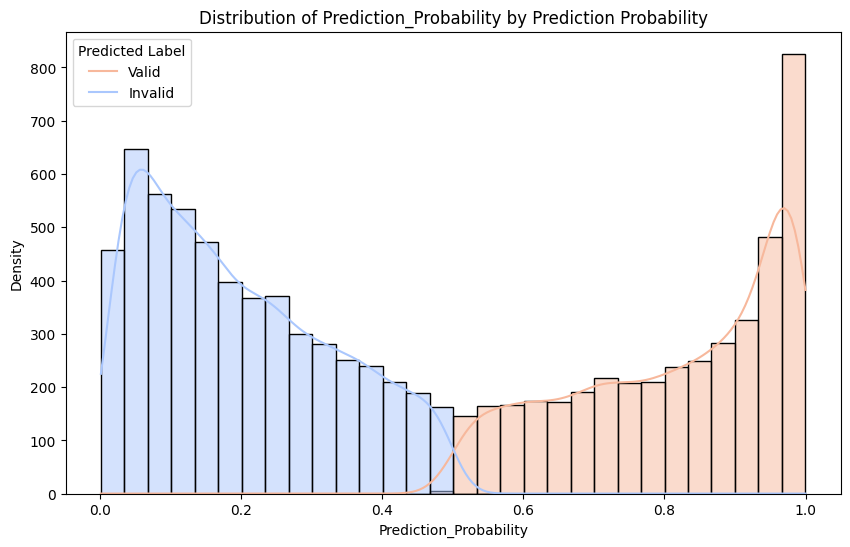

In [168]:
prediction_plots.plot_prediction_distribution(X_unlabeled, "Prediction_Probability")

### 20.1. Compute Density Using k-NN (Lower Distance = Higher Density)

In [161]:
feature_cols = ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8']

In [163]:
n_samples=68
k=10

In [164]:
knn = NearestNeighbors(n_neighbors=k, metric="euclidean")
knn.fit(X_unlabeled[feature_cols])  # Fit on the entire dataset for a global density measure

distances, _ = knn.kneighbors(X_unlabeled[feature_cols])
X_unlabeled["Density"] = distances.mean(axis=1)  # Lower values = More dense

In [166]:
X_unlabeled

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,Prediction_Probability,Predicted_Label,Density
1,3.585135,-0.946808,2.376782,2.239764,-3.176920,2.106953,0.309647,2.933195,-1.158072,0.489698,0,2.453245
2,-2.742050,1.946119,-1.012712,0.685001,-1.908302,1.280182,0.672111,-2.846945,0.034289,0.029115,0,1.407943
3,2.221016,-2.114839,-0.581277,-0.918493,-2.130092,1.277796,-1.356373,2.031235,-0.356917,0.793378,1,1.919478
4,1.158894,1.254940,1.802472,-1.573036,3.036069,-1.088067,1.846690,0.864903,3.867652,0.999251,1,2.255406
5,2.306618,-0.112240,1.393912,-2.066232,3.605497,-1.690781,0.999304,-0.143160,0.133154,0.985963,1,2.017533
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.254629,0.987995,1.085303,0.754103,-1.873603,2.832344,0.888712,-0.284633,0.166439,0.367829,0,1.470670
9996,1.073652,0.185000,0.143480,-2.513347,-2.305778,2.473852,0.231224,-1.293591,-2.147594,0.047365,0,1.862374
9997,-0.817159,0.774298,-0.053580,-0.902037,-4.125627,-0.264479,0.278698,-0.891123,-0.002447,0.047963,0,1.362997
9998,1.906176,1.968500,2.200580,0.724599,1.300840,-1.436129,0.572093,-1.045775,3.091766,0.980389,1,1.390807


In [167]:
df_most_diverse = X_unlabeled.nlargest(n_samples, "Density")
df_most_diverse

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,Prediction_Probability,Predicted_Label,Density
4063,5.155956,-0.650260,-4.256054,-0.169936,-2.425781,6.418203,-1.050601,-5.452573,3.005036,0.765740,1,4.591809
5021,0.854036,2.949263,5.448741,-0.650438,-0.941314,-6.200258,-0.257765,3.061585,6.204223,0.998903,1,4.447325
9269,2.332789,-2.362008,1.336327,0.314078,-7.135194,2.228070,-0.916203,3.642559,-4.554574,0.004230,0,4.105187
3479,-0.475902,-0.508198,-5.665437,2.159433,6.463942,2.245915,-1.579762,-5.059875,3.282346,0.996531,1,4.010434
9111,-0.057568,-0.010131,-5.237633,0.102891,-0.896615,7.585587,-1.080912,-4.398735,1.948524,0.483328,0,3.997895
...,...,...,...,...,...,...,...,...,...,...,...,...
2284,1.632535,1.534925,2.707035,2.658056,-4.052842,-1.682293,1.814987,0.838103,2.696526,0.647005,1,2.880783
2153,3.975888,0.968458,2.968188,-1.040860,1.596243,-4.551972,-0.083601,0.070661,4.074979,0.998799,1,2.879009
5684,4.333768,-3.350570,-3.042291,-0.555460,1.594588,3.332129,0.062060,-2.108788,-3.411744,0.502837,1,2.876942
5443,-2.011346,1.923206,1.212325,0.250851,-5.607577,0.026909,-0.737479,1.671989,3.377371,0.407161,0,2.873690


## 21. You've manually labeled another 68 samples
* Let's add them to the train set and train another model and see the performance

In [169]:
df_i4_68_labeled = df[df['label'].index.isin(df_most_diverse.index)]
df_i4_68_labeled

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,label
203,1.462080,-1.807110,-6.636689,-1.477451,5.630333,5.220079,0.452464,-5.121105,2.007813,1
245,-0.802736,-3.298906,-5.508045,-0.063050,3.996994,-2.950365,-0.321176,-1.742125,0.707036,0
470,-3.111053,-0.558199,-4.357081,2.196073,3.088198,-4.721674,-1.452669,-3.447670,2.276042,0
794,-2.210809,2.334162,0.362981,-2.039202,-3.759599,1.809306,2.288345,-2.081998,-0.659754,0
1155,1.425755,1.131205,4.496877,1.139845,-3.410803,-5.132273,0.402306,3.685694,3.140475,1
...,...,...,...,...,...,...,...,...,...,...
9424,0.757645,-1.081499,2.175157,-1.324562,-5.698761,-1.362833,0.992123,4.479118,-0.640023,1
9432,-2.279542,1.728453,-3.318632,0.830605,3.327597,-0.031221,-2.645882,-4.124739,5.235174,1
9657,-4.795720,2.402070,-3.272077,-0.408994,0.035557,-1.102496,1.611780,-4.455396,3.682244,0
9806,0.555467,-1.042878,-0.927880,-2.436310,-4.498399,-3.811271,-1.704060,-0.353855,0.600374,0


In [170]:
pd.concat([df_i4, df_i4_68_labeled]).to_csv('data/i5_572_labeled_data.csv')

# Iteration 5 `i5`

## 22. So now you have manually labeled 572 samples in total
* 300 to start with iteration 1 (cummulative total: 300)
* 68 to start with iteration 2 (cummulative total: 368)
* 68 to start with iteration 3 (cummulative total: 436)
* 68 to start with iteration 4 (cummulative total: 504)
* 68 to start with iteration 5 (cummulative total: 572)

In [171]:
df_i5 = pd.read_csv('data/i5_572_labeled_data.csv', index_col=0)

In [172]:
X_unlabeled = pd.read_csv('data/data_unlabeled.csv')
X_unlabeled.shape

(10000, 10)

### There are now 9,428 unlabeled samples (10,000 - 572)

In [173]:
labeled_indices = df_i5.index
len(labeled_indices)

572

In [174]:
print(X_unlabeled.shape)
all_indices = np.arange(len(X_unlabeled))
print(len(all_indices))

(10000, 10)
10000


In [175]:
non_labeled_indices = np.setdiff1d(all_indices, labeled_indices)
print(len(non_labeled_indices))
X_unlabeled = df.iloc[non_labeled_indices].drop(columns='label')
print(X_unlabeled.shape)

9428
(9428, 9)


In [176]:
X_unlabeled

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8
1,3.585135,-0.946808,2.376782,2.239764,-3.176920,2.106953,0.309647,2.933195,-1.158072
2,-2.742050,1.946119,-1.012712,0.685001,-1.908302,1.280182,0.672111,-2.846945,0.034289
3,2.221016,-2.114839,-0.581277,-0.918493,-2.130092,1.277796,-1.356373,2.031235,-0.356917
4,1.158894,1.254940,1.802472,-1.573036,3.036069,-1.088067,1.846690,0.864903,3.867652
5,2.306618,-0.112240,1.393912,-2.066232,3.605497,-1.690781,0.999304,-0.143160,0.133154
...,...,...,...,...,...,...,...,...,...
9995,1.254629,0.987995,1.085303,0.754103,-1.873603,2.832344,0.888712,-0.284633,0.166439
9996,1.073652,0.185000,0.143480,-2.513347,-2.305778,2.473852,0.231224,-1.293591,-2.147594
9997,-0.817159,0.774298,-0.053580,-0.902037,-4.125627,-0.264479,0.278698,-0.891123,-0.002447
9998,1.906176,1.968500,2.200580,0.724599,1.300840,-1.436129,0.572093,-1.045775,3.091766


## 23. Train model on 572 labeled samples

### 23.1. Train/Test Split

In [177]:
X = df_i5.drop(columns=['label'])
y = df_i5['label']

In [178]:
X

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8
41,1.108881,1.321525,1.497555,0.262076,-1.712964,0.218810,-0.991417,-1.712821,-0.992199
146,0.960339,3.072138,1.507638,0.286201,-1.126263,0.545994,-2.066957,-3.653898,1.666626
190,-0.175840,-0.097161,-2.908148,0.925595,-0.357026,2.596895,-0.583683,-3.526364,-0.479135
197,2.593124,0.784321,0.477026,1.030054,-2.424044,0.970779,-0.590778,-1.982502,0.980651
224,-0.274208,1.748403,0.956716,-0.503438,-0.652381,1.779665,1.150987,-1.637511,-0.564733
...,...,...,...,...,...,...,...,...,...
9424,0.757645,-1.081499,2.175157,-1.324562,-5.698761,-1.362833,0.992123,4.479118,-0.640023
9432,-2.279542,1.728453,-3.318632,0.830605,3.327597,-0.031221,-2.645882,-4.124739,5.235174
9657,-4.795720,2.402070,-3.272077,-0.408994,0.035557,-1.102496,1.611780,-4.455396,3.682244
9806,0.555467,-1.042878,-0.927880,-2.436310,-4.498399,-3.811271,-1.704060,-0.353855,0.600374


In [179]:
y.value_counts()

label
1    288
0    284
Name: count, dtype: int64

### 23.2. Nested Cross-Validation
* Nested Cross-Validation
    * Wraps Grid Search inside an outer Cross-Validation loop to get an unbiased estimate of model performance, especially when tuning hyperparameters.

* Grid Search
    * Hyperparameter Tuning (Regularization Strength) with Cross-Validation

In [180]:
# Define hyperparameter space and CV strategies
param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100]}
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# Perform nested CV
fold_results = []
all_best_params = []

for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):
    X_train_outer, X_test_outer = X.iloc[train_idx], X.iloc[test_idx]
    y_train_outer, y_test_outer = y.iloc[train_idx], y.iloc[test_idx]
    
    # Inner Grid Search
    grid_search = GridSearchCV(
        estimator=LogisticRegression(max_iter=500, random_state=42),
        param_grid=param_grid,
        cv=inner_cv,
        scoring='f1',
        n_jobs=-1
    )
    grid_search.fit(X_train_outer, y_train_outer)
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    all_best_params.append(best_params)
    
    # Outer evaluation
    y_pred_outer = best_model.predict(X_test_outer)
    precision = precision_score(y_test_outer, y_pred_outer)
    recall = recall_score(y_test_outer, y_pred_outer)
    f1 = f1_score(y_test_outer, y_pred_outer)
    
    # Store fold results
    fold_results.append({
        "Fold": f"Fold {fold_idx}",
        "Precision": round(precision, 3),
        "Recall": round(recall, 3),
        "F1 Score": round(f1, 3),
        "Best Params": best_params
    })

In [181]:
# Step 5: Build results DataFrame
results_df = pd.DataFrame(fold_results)

# Step 6: Determine most frequent best params and retrain on full labeled set
best_overall_params = pd.DataFrame(all_best_params).mode().iloc[0].to_dict()
final_model = LogisticRegression(**best_overall_params, max_iter=500, random_state=42)
final_model.fit(X, y)

LogisticRegression(C=0.1, max_iter=500, random_state=42)

In [182]:
joblib.dump(final_model, "model/i5_logistic_pipeline_v1.pkl")

['model/i5_logistic_pipeline_v1.pkl']

In [183]:
results_df

,Fold,Precision,Recall,F1 Score,Best Params
0,Fold 1,0.645,0.845,0.731,{'C': 10}
1,Fold 2,0.783,0.621,0.692,{'C': 0.01}
2,Fold 3,0.673,0.649,0.661,{'C': 100}
3,Fold 4,0.727,0.702,0.714,{'C': 0.1}
4,Fold 5,0.737,0.724,0.730,{'C': 0.1}


In [184]:
best_overall_params

{'C': 0.1}

## 24. Use the model to Predict on all samples

In [185]:
X_unlabeled

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8
1,3.585135,-0.946808,2.376782,2.239764,-3.176920,2.106953,0.309647,2.933195,-1.158072
2,-2.742050,1.946119,-1.012712,0.685001,-1.908302,1.280182,0.672111,-2.846945,0.034289
3,2.221016,-2.114839,-0.581277,-0.918493,-2.130092,1.277796,-1.356373,2.031235,-0.356917
4,1.158894,1.254940,1.802472,-1.573036,3.036069,-1.088067,1.846690,0.864903,3.867652
5,2.306618,-0.112240,1.393912,-2.066232,3.605497,-1.690781,0.999304,-0.143160,0.133154
...,...,...,...,...,...,...,...,...,...
9995,1.254629,0.987995,1.085303,0.754103,-1.873603,2.832344,0.888712,-0.284633,0.166439
9996,1.073652,0.185000,0.143480,-2.513347,-2.305778,2.473852,0.231224,-1.293591,-2.147594
9997,-0.817159,0.774298,-0.053580,-0.902037,-4.125627,-0.264479,0.278698,-0.891123,-0.002447
9998,1.906176,1.968500,2.200580,0.724599,1.300840,-1.436129,0.572093,-1.045775,3.091766


In [186]:
new_probabilities = final_model.predict_proba(X_unlabeled)[:, 1]  # Get probability scores
X_unlabeled["Prediction_Probability"] = new_probabilities

In [187]:
threshold = 0.50
lower_threshold = threshold - 0.05
upper_threshold = threshold + 0.05
highlight_bins = [f"({lower_threshold}, {threshold}]", f"({threshold}, {upper_threshold}]"]
sample_size = 68
print(highlight_bins)

['(0.45, 0.5]', '(0.5, 0.55]']


In [188]:
# Add predictions to the new dataset
X_unlabeled["Predicted_Label"] = [1 if prob > threshold else 0 for prob in X_unlabeled["Prediction_Probability"]]

## 25. Use `KNN Diverse Sampling` to find out what to label on the next iteration
* From the most diverse, find 68 samples to manually label them

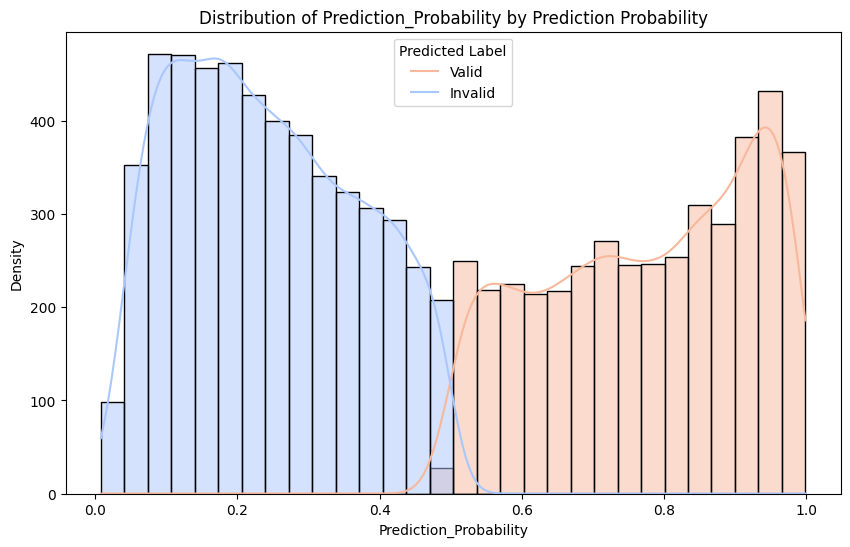

In [189]:
prediction_plots.plot_prediction_distribution(X_unlabeled, "Prediction_Probability")

### 25.1. Compute Density Using k-NN (Lower Distance = Higher Density)

In [190]:
feature_cols = ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8']

In [191]:
n_samples=68
k=10

In [192]:
knn = NearestNeighbors(n_neighbors=k, metric="euclidean")
knn.fit(X_unlabeled[feature_cols])  # Fit on the entire dataset for a global density measure

distances, _ = knn.kneighbors(X_unlabeled[feature_cols])
X_unlabeled["Density"] = distances.mean(axis=1)  # Lower values = More dense

In [193]:
X_unlabeled

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,Prediction_Probability,Predicted_Label,Density
1,3.585135,-0.946808,2.376782,2.239764,-3.176920,2.106953,0.309647,2.933195,-1.158072,0.698588,1,2.453245
2,-2.742050,1.946119,-1.012712,0.685001,-1.908302,1.280182,0.672111,-2.846945,0.034289,0.056229,0,1.407943
3,2.221016,-2.114839,-0.581277,-0.918493,-2.130092,1.277796,-1.356373,2.031235,-0.356917,0.836953,1,1.919478
4,1.158894,1.254940,1.802472,-1.573036,3.036069,-1.088067,1.846690,0.864903,3.867652,0.996645,1,2.255406
5,2.306618,-0.112240,1.393912,-2.066232,3.605497,-1.690781,0.999304,-0.143160,0.133154,0.963350,1,2.017533
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.254629,0.987995,1.085303,0.754103,-1.873603,2.832344,0.888712,-0.284633,0.166439,0.509836,1,1.470670
9996,1.073652,0.185000,0.143480,-2.513347,-2.305778,2.473852,0.231224,-1.293591,-2.147594,0.114967,0,1.862374
9997,-0.817159,0.774298,-0.053580,-0.902037,-4.125627,-0.264479,0.278698,-0.891123,-0.002447,0.092746,0,1.362997
9998,1.906176,1.968500,2.200580,0.724599,1.300840,-1.436129,0.572093,-1.045775,3.091766,0.950592,1,1.390807


In [194]:
df_most_diverse = X_unlabeled.nlargest(n_samples, "Density")
df_most_diverse

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,Prediction_Probability,Predicted_Label,Density
492,-0.266212,1.460369,-2.337834,-1.355076,3.759393,-0.680157,0.758334,-3.808198,5.422006,0.988344,1,2.937366
209,2.155045,2.945654,2.815713,1.088278,-1.170689,-3.969692,-1.122225,-2.761246,3.524344,0.637537,1,2.905718
5533,2.193040,1.355278,4.047152,-0.064782,-4.680031,-3.221600,-0.057854,3.118208,4.077224,0.939375,1,2.879970
5173,-2.350719,1.734581,2.011309,0.877364,-4.376714,-2.357237,-1.404151,2.395236,2.777341,0.572323,1,2.877719
6300,-0.074177,-0.278733,1.759428,-0.023818,-5.488609,-0.903345,2.087661,3.378213,0.071744,0.392769,0,2.875893
...,...,...,...,...,...,...,...,...,...,...,...,...
9896,-0.155456,-1.652130,-3.633429,-0.239056,1.738820,2.323956,-0.680183,-3.275313,-3.435739,0.120209,0,2.676039
2903,-3.031478,0.228255,-3.873697,0.136448,1.132544,-3.726669,1.382082,-4.808512,0.765204,0.137750,0,2.675052
5135,-1.171584,-2.024070,-5.170307,1.022420,0.565821,4.903953,-1.625412,-1.261189,-0.009914,0.726904,1,2.673544
5753,1.904644,-1.938576,-4.363415,2.233469,-0.696216,5.450607,0.545999,-3.438437,-1.847266,0.193784,0,2.672298


## 26. You've manually labeled another 68 samples
* Let's add them to the train set and train another model and see the performance

In [195]:
df_i5_68_labeled = df[df['label'].index.isin(df_most_diverse.index)]
df_i5_68_labeled

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,label
43,2.515183,-1.138767,-4.619655,-0.602970,3.215200,4.293228,1.973585,-5.014650,0.938432,1
209,2.155045,2.945654,2.815713,1.088278,-1.170689,-3.969692,-1.122225,-2.761246,3.524344,1
211,1.553911,-2.360926,-0.478660,-2.809339,-2.966905,1.259113,1.945403,2.005059,-2.644342,1
279,1.083331,-0.822112,-1.413396,1.930945,-5.916328,1.466979,-0.201093,-0.577732,-0.064984,0
325,4.809293,1.152826,0.828776,1.358554,-2.884278,3.671883,-0.227487,-1.553583,3.757998,0
...,...,...,...,...,...,...,...,...,...,...
9300,-1.729254,0.235879,-0.031351,1.791912,0.107133,-4.822659,3.037682,-1.336118,-1.147572,0
9301,-2.745152,-0.946568,-3.936652,0.224846,3.066653,-4.102198,-1.383084,-2.441553,1.648340,0
9405,3.448951,-0.674382,0.265961,-1.450981,-5.367723,3.937469,-1.847386,-0.164497,-1.367067,1
9425,-2.337461,-0.367647,-2.285157,2.649977,1.710549,-3.869894,2.345981,-2.452472,-0.456550,0


In [196]:
pd.concat([df_i5, df_i5_68_labeled]).to_csv('data/i6_640_labeled_data.csv')

## 27. The end
* Or not, you can continue until you feel comfortable that your model is generalizing well the whole dataset
* If you stop here you would use the Prediction_Probability together with a threshold like 0.5 to define what is the Predicted_Labeled for the whole dataset 1 or 0s.

In [ ]:
X_unlabeled

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,Prediction_Probability,Predicted_Label,Density
1,3.585135,-0.946808,2.376782,2.239764,-3.176920,2.106953,0.309647,2.933195,-1.158072,0.698588,1,2.453245
2,-2.742050,1.946119,-1.012712,0.685001,-1.908302,1.280182,0.672111,-2.846945,0.034289,0.056229,0,1.407943
3,2.221016,-2.114839,-0.581277,-0.918493,-2.130092,1.277796,-1.356373,2.031235,-0.356917,0.836953,1,1.919478
4,1.158894,1.254940,1.802472,-1.573036,3.036069,-1.088067,1.846690,0.864903,3.867652,0.996645,1,2.255406
5,2.306618,-0.112240,1.393912,-2.066232,3.605497,-1.690781,0.999304,-0.143160,0.133154,0.963350,1,2.017533
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.254629,0.987995,1.085303,0.754103,-1.873603,2.832344,0.888712,-0.284633,0.166439,0.509836,1,1.470670
9996,1.073652,0.185000,0.143480,-2.513347,-2.305778,2.473852,0.231224,-1.293591,-2.147594,0.114967,0,1.862374
9997,-0.817159,0.774298,-0.053580,-0.902037,-4.125627,-0.264479,0.278698,-0.891123,-0.002447,0.092746,0,1.362997
9998,1.906176,1.968500,2.200580,0.724599,1.300840,-1.436129,0.572093,-1.045775,3.091766,0.950592,1,1.390807


# Iteration 6 `i6`

## 28. So now you have manually labeled 640 samples in total
* 300 to start with iteration 1 (cummulative total: 300)
* 68 to start with iteration 2 (cummulative total: 368)
* 68 to start with iteration 3 (cummulative total: 436)
* 68 to start with iteration 4 (cummulative total: 504)
* 68 to start with iteration 5 (cummulative total: 572)
* 68 to start with iteration 6 (cummulative total: 640)

In [207]:
df_i6 = pd.read_csv('data/i6_640_labeled_data.csv', index_col=0)

In [208]:
X_unlabeled = pd.read_csv('data/data_unlabeled.csv')
X_unlabeled.shape

(10000, 10)

### There are now 9,360 unlabeled samples (10,000 - 640)

In [209]:
labeled_indices = df_i6.index
len(labeled_indices)

640

In [210]:
print(X_unlabeled.shape)
all_indices = np.arange(len(X_unlabeled))
print(len(all_indices))

(10000, 10)
10000


In [211]:
non_labeled_indices = np.setdiff1d(all_indices, labeled_indices)
print(len(non_labeled_indices))
X_unlabeled = df.iloc[non_labeled_indices].drop(columns='label')
print(X_unlabeled.shape)

9360
(9360, 9)


In [212]:
X_unlabeled

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8
1,3.585135,-0.946808,2.376782,2.239764,-3.176920,2.106953,0.309647,2.933195,-1.158072
2,-2.742050,1.946119,-1.012712,0.685001,-1.908302,1.280182,0.672111,-2.846945,0.034289
3,2.221016,-2.114839,-0.581277,-0.918493,-2.130092,1.277796,-1.356373,2.031235,-0.356917
4,1.158894,1.254940,1.802472,-1.573036,3.036069,-1.088067,1.846690,0.864903,3.867652
5,2.306618,-0.112240,1.393912,-2.066232,3.605497,-1.690781,0.999304,-0.143160,0.133154
...,...,...,...,...,...,...,...,...,...
9995,1.254629,0.987995,1.085303,0.754103,-1.873603,2.832344,0.888712,-0.284633,0.166439
9996,1.073652,0.185000,0.143480,-2.513347,-2.305778,2.473852,0.231224,-1.293591,-2.147594
9997,-0.817159,0.774298,-0.053580,-0.902037,-4.125627,-0.264479,0.278698,-0.891123,-0.002447
9998,1.906176,1.968500,2.200580,0.724599,1.300840,-1.436129,0.572093,-1.045775,3.091766


## 29. Train model on 640 labeled samples

### 29.1. Train/Test Split

In [217]:
X = df_i6.drop(columns=['label'])
y = df_i6['label']

In [218]:
y.value_counts()

label
1    334
0    306
Name: count, dtype: int64

In [219]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(448, 9) (192, 9) (448,) (192,)


### 29.2. Train `QBC (Query By Committee)`

In [225]:
models = query_by_committee.train_qbc_committee(X_train, y_train)


--- Hyperparameter Tuning for Logistic Regression ---

Best Parameters for LogisticRegression: {'C': 0.001}

LogisticRegression - Grid Search CV Performance Per Fold:
Fold 1: F1 Score = 0.8155, Precision = 0.7500, Recall = 0.8936
Fold 2: F1 Score = 0.7547, Precision = 0.6780, Recall = 0.8511
Fold 3: F1 Score = 0.7429, Precision = 0.6724, Recall = 0.8298
Fold 4: F1 Score = 0.7619, Precision = 0.6897, Recall = 0.8511

Mean CV F1 Score: 0.7688
Mean CV Precision: 0.6975
Mean CV Recall: 0.8564

--- Hyperparameter Tuning for Random Forest ---

Best Parameters for RandomForestClassifier: {'max_depth': 7, 'min_samples_leaf': 4, 'n_estimators': 100}

RandomForestClassifier - Grid Search CV Performance Per Fold:
Fold 1: F1 Score = 0.8776, Precision = 0.8431, Recall = 0.9149
Fold 2: F1 Score = 0.8421, Precision = 0.8333, Recall = 0.8511
Fold 3: F1 Score = 0.8667, Precision = 0.9070, Recall = 0.8298
Fold 4: F1 Score = 0.8454, Precision = 0.8200, Recall = 0.8723
Fold 5: F1 Score = 0.9451, Precisio

### 29.3. Stacking Model (Meta-Learner)

In [226]:
X_train

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8
1829,-0.201160,-0.185098,-1.879719,0.088081,-1.530823,2.227488,1.127135,-1.282222,0.463695
3721,-0.730989,-1.273110,-1.296751,0.390820,1.605280,-2.989462,0.195813,-0.599859,-1.422766
7958,2.556750,-0.063119,0.910917,-1.080463,-2.398252,2.784372,-1.457927,0.359804,-0.253362
8810,-1.356392,0.828225,-0.257963,-0.001470,-2.862688,-0.112022,1.234602,-0.840400,0.111643
9348,-0.147454,1.048239,0.557393,-1.187772,0.618336,-0.057536,0.917652,-1.994995,-1.350818
...,...,...,...,...,...,...,...,...,...
7533,-0.572419,-0.498419,-1.270644,-0.229337,-2.335365,-1.634105,1.084690,-0.510862,0.619743
6318,0.041374,0.392210,2.538954,0.014081,-0.962754,-4.295148,0.794483,1.952942,0.418788
7951,1.892434,0.114683,-0.690537,-1.780448,-0.705948,2.535549,0.102084,-2.112947,-0.276877
5013,0.507789,4.392908,2.440488,0.064357,-0.981015,0.324417,-0.573894,-3.708540,3.408878


In [227]:
X_train_with_scores = query_by_committee.stacking_models(X_train, models)
X_test_with_scores = query_by_committee.stacking_models(X_test, models)

In [228]:
X_train_with_scores[[
    'Logistic Regression_score',
    'Random Forest_score',
    'Extra Trees_score',
    'SVM_score']]

,Logistic Regression_score,Random Forest_score,Extra Trees_score,SVM_score
1829,0.507828,0.582444,0.486128,0.885918
3721,0.494593,0.129077,0.300705,0.016092
7958,0.549481,0.258342,0.416237,0.005661
8810,0.451964,0.159931,0.386307,0.030573
9348,0.480369,0.280267,0.422037,0.163697
...,...,...,...,...
7533,0.489555,0.404219,0.416255,0.176584
6318,0.527658,0.913076,0.656825,0.999991
7951,0.535136,0.247724,0.473054,0.071607
5013,0.539616,0.271263,0.489438,0.029045


In [229]:
X_test_with_scores[[
    'Logistic Regression_score',
    'Random Forest_score',
    'Extra Trees_score',
    'SVM_score']]

,Logistic Regression_score,Random Forest_score,Extra Trees_score,SVM_score
3755,0.506997,0.717976,0.569243,0.981003
9551,0.531971,0.918472,0.602983,0.999987
6435,0.591784,0.896331,0.682398,0.988400
3669,0.632765,0.903057,0.753208,1.000000
518,0.522785,0.520098,0.543925,0.982911
...,...,...,...,...
1567,0.500717,0.665943,0.522664,0.935557
1820,0.553936,0.276336,0.442359,0.000504
3156,0.629061,0.851019,0.655608,0.999998
1489,0.479652,0.258635,0.392182,0.045933


In [230]:
%%time
models_stacking = query_by_committee.train_qbc_committee(
    X_train_with_scores[[
        'Logistic Regression_score',
        'Random Forest_score',
        'Extra Trees_score',
        'SVM_score']], 
    y_train,
    cv_folds=5
)


--- Hyperparameter Tuning for Logistic Regression ---

Best Parameters for LogisticRegression: {'C': 0.1}

LogisticRegression - Grid Search CV Performance Per Fold:
Fold 1: F1 Score = 0.9895, Precision = 0.9792, Recall = 1.0000
Fold 2: F1 Score = 0.9565, Precision = 0.9778, Recall = 0.9362
Fold 3: F1 Score = 0.9783, Precision = 1.0000, Recall = 0.9574
Fold 4: F1 Score = 0.9783, Precision = 1.0000, Recall = 0.9574

Mean CV F1 Score: 0.9756
Mean CV Precision: 0.9892
Mean CV Recall: 0.9628

--- Hyperparameter Tuning for Random Forest ---

Best Parameters for RandomForestClassifier: {'max_depth': 3, 'min_samples_leaf': 4, 'n_estimators': 30}

RandomForestClassifier - Grid Search CV Performance Per Fold:
Fold 1: F1 Score = 0.9895, Precision = 0.9792, Recall = 1.0000
Fold 2: F1 Score = 0.9677, Precision = 0.9783, Recall = 0.9574
Fold 3: F1 Score = 0.9565, Precision = 0.9778, Recall = 0.9362
Fold 4: F1 Score = 0.9892, Precision = 1.0000, Recall = 0.9787
Fold 5: F1 Score = 0.9890, Precision =

In [232]:
results_stacking = model_evaluation.evaluate_model(
    models_stacking['Logistic Regression'], 
    X_train_with_scores[[
        'Logistic Regression_score',
        'Random Forest_score',
        'Extra Trees_score',
        'SVM_score']], 
    y_train, 
    threshold=0.50
)

Model Performance (Threshold = 0.5):
Accuracy: 0.9799
Precision: 0.9913
Recall: 0.9701
F1 Score: 0.9806
ROC-AUC Score: 0.9959


In [233]:
results_stacking = model_evaluation.evaluate_model(
    models_stacking['Logistic Regression'], 
    X_test_with_scores[[
        'Logistic Regression_score',
        'Random Forest_score',
        'Extra Trees_score',
        'SVM_score']], 
    y_test, 
    threshold=0.50
)

Model Performance (Threshold = 0.5):
Accuracy: 0.9323
Precision: 0.9223
Recall: 0.9500
F1 Score: 0.9360
ROC-AUC Score: 0.9735


## 30. Use the model to Predict on all samples

In [238]:
n_samples = 68

In [235]:
X_unlabeled = query_by_committee.select_qbc_samples(X_unlabeled, models)

In [236]:
X_unlabeled

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,Logistic Regression_score,Random Forest_score,Extra Trees_score,SVM_score,disagreement_score
1,3.585135,-0.946808,2.376782,2.239764,-3.176920,2.106953,0.309647,2.933195,-1.158072,0.556028,0.481307,0.542196,0.096549,0.035453
2,-2.742050,1.946119,-1.012712,0.685001,-1.908302,1.280182,0.672111,-2.846945,0.034289,0.417142,0.105360,0.352167,0.002588,0.029185
3,2.221016,-2.114839,-0.581277,-0.918493,-2.130092,1.277796,-1.356373,2.031235,-0.356917,0.567002,0.565071,0.566191,0.971727,0.030852
4,1.158894,1.254940,1.802472,-1.573036,3.036069,-1.088067,1.846690,0.864903,3.867652,0.675452,0.948822,0.820765,1.000000,0.015770
5,2.306618,-0.112240,1.393912,-2.066232,3.605497,-1.690781,0.999304,-0.143160,0.133154,0.619598,0.912656,0.730387,1.000000,0.022275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.254629,0.987995,1.085303,0.754103,-1.873603,2.832344,0.888712,-0.284633,0.166439,0.527017,0.303266,0.405477,0.002262,0.037740
9996,1.073652,0.185000,0.143480,-2.513347,-2.305778,2.473852,0.231224,-1.293591,-2.147594,0.465583,0.245254,0.385597,0.002082,0.030980
9997,-0.817159,0.774298,-0.053580,-0.902037,-4.125627,-0.264479,0.278698,-0.891123,-0.002447,0.442088,0.388241,0.446837,0.022402,0.031030
9998,1.906176,1.968500,2.200580,0.724599,1.300840,-1.436129,0.572093,-1.045775,3.091766,0.619805,0.947044,0.728364,0.999999,0.024239


In [237]:
X_unlabeled.sort_values(by='disagreement_score', ascending=False)

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,Logistic Regression_score,Random Forest_score,Extra Trees_score,SVM_score,disagreement_score
2969,-0.820338,-2.377557,-4.535427,0.721760,0.596237,-2.747710,1.206763,-1.769689,0.932111,0.523954,0.668945,0.455456,0.001252,0.062289
6434,4.230914,-0.767089,0.725201,-0.931729,-2.842720,3.212926,1.126938,0.910397,0.756252,0.603422,0.606436,0.493377,0.010577,0.060282
5002,-0.298087,4.267498,4.714444,0.395590,0.112760,-3.227824,-0.476089,-1.759000,1.166301,0.498725,0.698809,0.480949,0.030692,0.059749
3151,1.601829,3.100337,3.726521,0.738954,-2.208337,-0.776301,-1.105725,-1.267714,1.530445,0.525240,0.639263,0.552290,0.025489,0.057830
2419,3.750461,0.109820,2.749083,-0.319184,-2.975349,1.565632,0.275741,2.009583,0.662831,0.591697,0.747330,0.573543,0.109164,0.056906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3004,-0.688320,1.573424,-1.758481,0.443957,-1.589383,2.179961,2.243900,-3.910395,1.266242,0.478334,0.489048,0.517216,0.490004,0.000206
5344,-1.173929,1.259360,-0.472123,-2.803162,-2.279221,-0.558069,-0.304088,-1.346742,1.979674,0.504125,0.502822,0.508742,0.536599,0.000189
3470,0.080403,1.939593,1.169627,-0.056720,0.699148,-0.671341,0.545860,-2.665433,-0.233450,0.494047,0.513215,0.511559,0.518037,0.000082
8701,0.220435,1.171868,0.016153,0.927141,0.053572,0.318842,-2.003556,-2.911405,-0.787773,0.477290,0.481422,0.482380,0.461277,0.000072


In [240]:
df_most_disagreement = X_unlabeled.nlargest(n_samples, "disagreement_score")
df_most_disagreement

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,Logistic Regression_score,Random Forest_score,Extra Trees_score,SVM_score,disagreement_score
2969,-0.820338,-2.377557,-4.535427,0.721760,0.596237,-2.747710,1.206763,-1.769689,0.932111,0.523954,0.668945,0.455456,0.001252,0.062289
6434,4.230914,-0.767089,0.725201,-0.931729,-2.842720,3.212926,1.126938,0.910397,0.756252,0.603422,0.606436,0.493377,0.010577,0.060282
5002,-0.298087,4.267498,4.714444,0.395590,0.112760,-3.227824,-0.476089,-1.759000,1.166301,0.498725,0.698809,0.480949,0.030692,0.059749
3151,1.601829,3.100337,3.726521,0.738954,-2.208337,-0.776301,-1.105725,-1.267714,1.530445,0.525240,0.639263,0.552290,0.025489,0.057830
2419,3.750461,0.109820,2.749083,-0.319184,-2.975349,1.565632,0.275741,2.009583,0.662831,0.591697,0.747330,0.573543,0.109164,0.056906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8681,1.693062,3.831436,2.973269,-1.197539,-2.110638,0.443281,-1.945989,-2.703432,3.188358,0.556148,0.428045,0.565494,0.023881,0.048462
2632,3.578540,0.513025,1.053753,-0.134285,-2.293603,2.549623,0.569540,-0.589657,1.412938,0.588710,0.314155,0.471574,0.002317,0.048449
2536,1.298971,0.550140,0.694084,0.988666,-0.679509,-1.642008,-0.189901,-1.871332,-0.484115,0.498530,0.387245,0.496718,0.957800,0.048339
2139,4.260503,0.614687,0.180186,-0.027876,-2.943440,2.676812,0.777417,-2.425566,1.742278,0.578517,0.239114,0.455302,0.001933,0.048210


## 31. You've manually labeled another 68 samples
* Let's add them to the train set and train another model and see the performance

In [242]:
df_i6_68_labeled = df[df['label'].index.isin(df_most_disagreement.index)]
df_i6_68_labeled

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,label
48,2.276059,3.454912,4.253276,-0.494794,-2.518806,-0.072787,0.482937,-0.754046,2.863898,0
214,-0.035733,0.947096,2.246562,1.591031,-0.753161,-2.994887,0.787407,0.414774,-0.321855,1
219,1.916032,0.159804,1.185601,-0.508267,-0.852528,-3.350876,0.149597,-1.221739,-0.264276,1
451,1.096046,-0.985078,-1.861893,-0.561275,-0.546944,1.777297,-0.025164,-1.324916,-0.418113,1
574,-0.395623,-2.247285,-4.388417,-1.587218,0.191825,-1.799028,-0.230356,-2.268030,0.137326,0
...,...,...,...,...,...,...,...,...,...,...
9562,-0.858915,-2.716331,-4.429242,-0.448482,2.905831,-1.226715,-0.661395,-1.459623,-0.777084,0
9609,-0.240892,3.757652,2.435458,0.457365,-0.262795,-0.760767,0.316774,-3.403850,1.214619,0
9730,3.119818,2.350032,2.097118,0.715577,-2.310387,1.568322,-1.468693,-1.794680,3.114117,0
9756,4.495646,-1.269973,-0.560044,-2.131446,-3.305704,4.992734,0.032110,0.285674,0.613181,0


In [243]:
pd.concat([df_i6, df_i6_68_labeled]).to_csv('data/i7_708_labeled_data.csv')

## 32. The end? 
* Retrain the model with the new labeled data and see how the performance improves and decide whether to continue or to finalize it